In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

In [4]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100

In [5]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

In [6]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='softmax'))
    return model

In [12]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='Adam')

In [17]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    z = np.random.normal(0,1,(image_grid_rows*image_grid_cols, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_cols, figsize=(4,4), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [15]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    (x_train, _),(_,_) = mnist.load_data()
    x_train = x_train /127.5 - 1.0
    x_train = np.expand_dims(x_train, axis=3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0,1,(batch_size,100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if(iteration+1)%sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0*accuracy)
            iteration_checkpoints.append(iteration+1)
            print('%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (iteration+1, d_loss, 100.0*accuracy, g_loss))
            
            sample_images(generator)

1000 [D loss: 0.318680, acc.: 50.00%] [G loss: 3.087474]
2000 [D loss: 0.393236, acc.: 50.00%] [G loss: 2.739041]
3000 [D loss: 0.316141, acc.: 50.00%] [G loss: 2.730421]
4000 [D loss: 0.314108, acc.: 50.00%] [G loss: 2.319240]
5000 [D loss: 0.498873, acc.: 50.00%] [G loss: 2.196792]


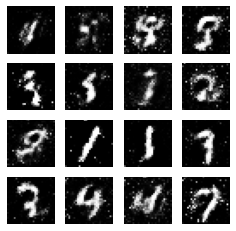

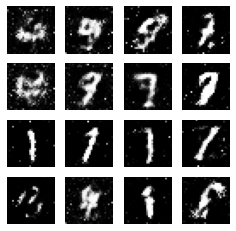

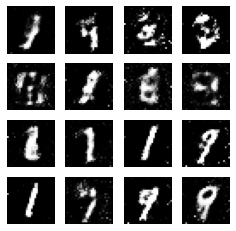

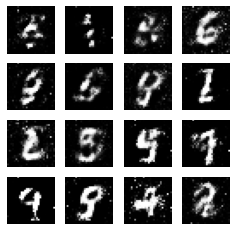

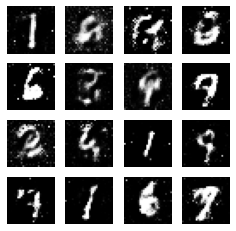

In [20]:
iterations = 5000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)